In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
!pip install Levenshtein
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from Levenshtein import distance as lev
import pandas as pd
import seaborn as sns

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input0 (InputLayer)         [(None, 2)]               0         
                                                                 
 Dense0 (Dense)              (None, 256)               768       
                                                                 
 Norm0 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense1 (Dense)              (None, 256)               65792     
                                                                 
 Norm1 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense2 (Dense)              (None, 256)               65792     
                                                                 
 Norm2 (BatchNormalization)  (None, 256)               1024  

In [4]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [5]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [6]:
oracle.summary()

Model: "MICPredictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SeqInput (InputLayer)       [(None, 190, 43)]            0         []                            
                                                                                                  
 Conv1D_0 (Conv1D)           (None, 186, 128)             27648     ['SeqInput[0][0]']            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 182, 128)             82048     ['Conv1D_0[0][0]']            
                                                                                                  
 Flatten_0 (Flatten)         (None, 23296)                0         ['Conv1D_1[0][0]']            
                                                                                       

In [7]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [8]:
def generate_sequences(generator, latent_dim, num_sequences):
    noise = (np.random.rand(num_sequences, latent_dim)-0.5)*2
    generated_sequences = generator.predict(noise, verbose=0)
    return onehot2seq(generated_sequences)

In [9]:
def onehot2seq(onehot):
  decoded_sequences = []
  for s in onehot:
    chars_array = pep_decoder(tf.math.argmax([s], axis=2)).numpy().astype('str')
    decoded_sequences += ["".join(chars) for chars in chars_array]
  return decoded_sequences

In [10]:
def coordinates_grid(num_bins) :
  labels = np.round(np.linspace(-1, 1, num_bins), 2)
  noise = []
  for x in labels:
    for y in labels:
        noise.append([x, y])
  noise = np.array(noise)
  num_sequences = len(noise)
  return noise, num_sequences, labels

In [11]:
def hallucination_mapping(num_bins, target):
  #Search coordinates in the noise plane
  noise, num_sequences, labels = coordinates_grid(num_bins)
  # Look up the index of the target bacteria
  bacteria = np.zeros(shape=(num_sequences, 326))
  index = np.where(species_vocal==target)[0][0]
  bacteria[:, index] = 1
  return noise, num_sequences, bacteria, labels

In [12]:
def visualization(noise, MIC, generated_sequences, num_bins, labels, num_sequences, iter, target):
    vis_data = np.concatenate([noise, np.array(generated_sequences).reshape(num_sequences, 1), MIC], axis=1)
    vis_data = pd.DataFrame(vis_data, columns=["Noise_1", "Noise_2", "Peptide", "MIC"])
    vis_data['MIC'] = vis_data['MIC'].astype('float64')
    vis_data['Noise_1'] = vis_data['Noise_1'].astype('float64')
    vis_data['Noise_2'] = vis_data['Noise_2'].astype('float64')
    vis_data['Noise_1_bins'] = pd.cut(vis_data['Noise_1'], bins=num_bins, labels=labels)
    vis_data['Noise_2_bins'] = pd.cut(vis_data['Noise_2'], bins=num_bins, labels=labels)

    #Print the sequence of the top peptide and its coordinates
    top_sequence = vis_data.sort_values(by=['MIC'], ascending=True).head(1)
    top_sequence.reset_index(drop=True)
    print(top_sequence[['Peptide', 'MIC', 'Noise_1', 'Noise_2']])

    # Group the data by the bins and calculate the mean MIC
    grouped = vis_data.groupby(['Noise_1_bins', 'Noise_2_bins'])
    grid_mic_mean = grouped['MIC'].mean().reset_index()

    # Pivot the results to create a grid that `sns.heatmap` can visualize
    grid_mic_mean_pivot = grid_mic_mean.pivot(index='Noise_1_bins', columns='Noise_2_bins', values='MIC')
    plt.figure()
    h = sns.heatmap(grid_mic_mean_pivot.transpose().iloc[::-1],
                cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Log2 MIC'})
    h.set(xlabel="Noise Dim 1", ylabel="Noise Dim 2", title=f"MIC Landscape for {target.split('_')[0]} {target.split('_')[1]} at iteration {iter}")
    plt.savefig(f"/content/AMPLify-Feedback-main/Bacterium2Peptide/Pictures/{target}_{iter+1}.png", dpi=200, bbox_inches='tight')
    plt.show()


In [13]:
@tf.function
def compute_gradient(noise, oracle, bacteria, generator_optimizer):
    noise = tf.convert_to_tensor(noise, np.float64)
    with tf.GradientTape() as gen_tape:
        gen_tape.watch(noise)
        generated_onehot = generator(noise, training=True)
        generator_loss = tf.reduce_mean(oracle([generated_onehot, bacteria]))
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return generated_onehot

In [14]:
def RL_loop(generator, oracle, aa_vocal, pep_decoder, n_bins, target):
  average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], []
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for i in range (n_iter_max) :
    #Sequences prediction and gradient computation
    noise, num_sequences, bacteria, labels = hallucination_mapping(n_bins, target)
    generated_onehot = compute_gradient(noise, oracle, bacteria, generator_optimizer)
    generated_sequences = onehot2seq(generated_onehot)

    #Oracle results and statistics
    MIC = oracle([generated_onehot, bacteria])
    average_mic_train += [np.mean(MIC)]
    min_mic_train += [np.min(MIC)]
    max_mic_train += [np.max(MIC)]
    median_mic_train += [np.median(MIC)]
    levenstein += [variability_metrics(generated_sequences, aa_vocal, pep_decoder)]

    #Visualization of the hallucination map and the top sequences
    print(f"Iter {i+1}/{n_iter_max}; Average MIC {np.mean(MIC):.4f}; Levenshtein {variability_metrics(generated_sequences, aa_vocal, pep_decoder):.4f}")
    visualization(noise, MIC, generated_sequences, n_bins, labels, num_sequences, i, target)

  return average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein

In [15]:
def variability_metrics(sequences, aa_vocal, pep_decoder):
  total_lev = 0
  index = 0
  for s1 in range(len(sequences)):
                for s2 in range(s1+1,len(sequences)):
                        total_lev += lev(sequences[s1],sequences[s2])
                        index += 1
  return total_lev/index

In [16]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.savefig(f"/content/AMPLify-Feedback-main/Bacterium2Peptide/Pictures/{list(parameters.keys())[0]}.png", dpi=200, bbox_inches='tight')
  plt.show()

Iter 1/70; Average MIC 3.8666; Levenshtein 7.4898
              Peptide       MIC  Noise_1  Noise_2
10135  EVGAkDGKkKLLKK  1.615379      1.0     -0.3


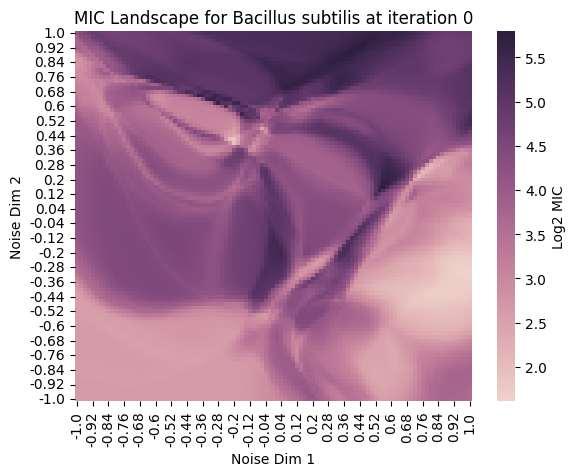

Iter 2/70; Average MIC 3.3404; Levenshtein 7.7547
             Peptide       MIC  Noise_1  Noise_2
8924  EVGAkDGKkKLLKK  1.625332     0.76    -0.28


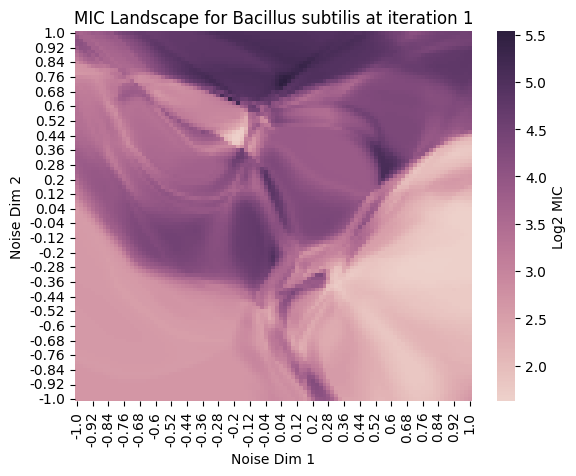

Iter 3/70; Average MIC 2.9852; Levenshtein 7.8480
         Peptide       MIC  Noise_1  Noise_2
6604  DVKKLDKHHK  1.459931      0.3    -0.22


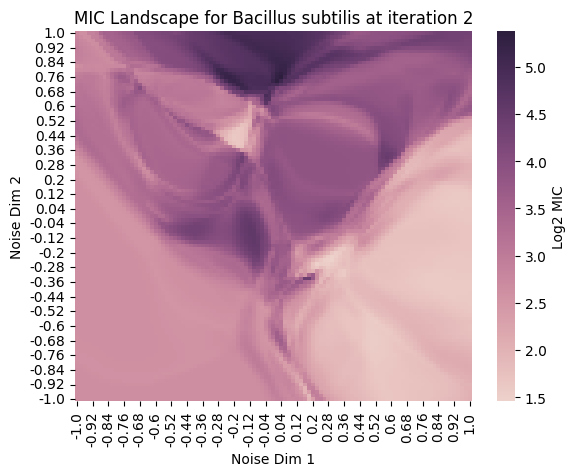

Iter 4/70; Average MIC 2.7573; Levenshtein 7.9685
          Peptide       MIC  Noise_1  Noise_2
6199  DVKKLDKFHKL  1.345564     0.22    -0.24


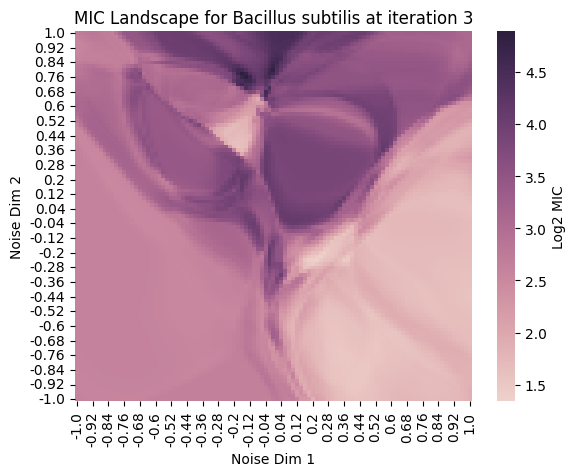

Iter 5/70; Average MIC 2.5949; Levenshtein 8.0830
         Peptide       MIC  Noise_1  Noise_2
5797  DVKKLDKFHK  1.354442     0.14     -0.2


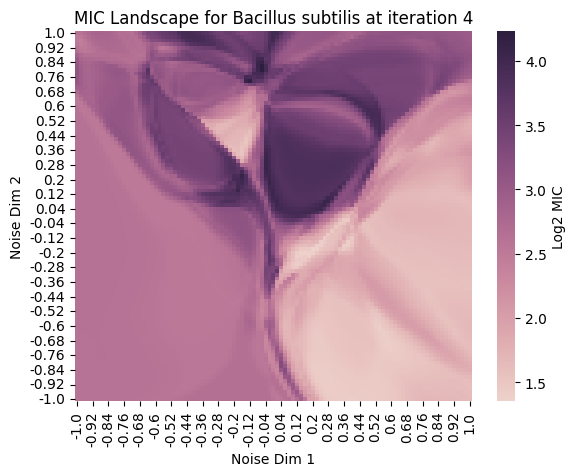

Iter 6/70; Average MIC 2.4563; Levenshtein 8.1989
          Peptide       MIC  Noise_1  Noise_2
5596  EVLKLDKFHLL  1.186874      0.1    -0.18


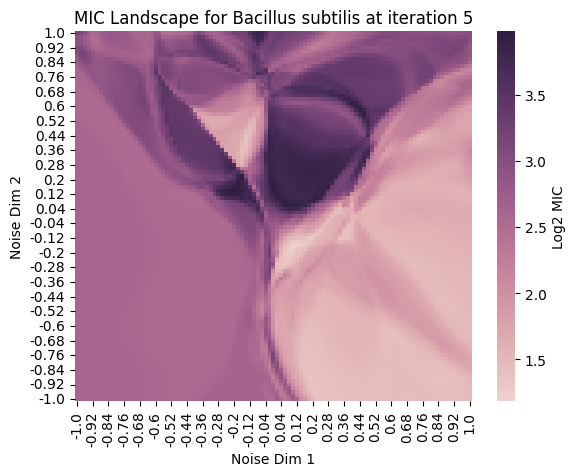

Iter 7/70; Average MIC 2.3134; Levenshtein 8.3137
          Peptide       MIC  Noise_1  Noise_2
5396  EVLKLDKFHLL  1.076585     0.06    -0.14


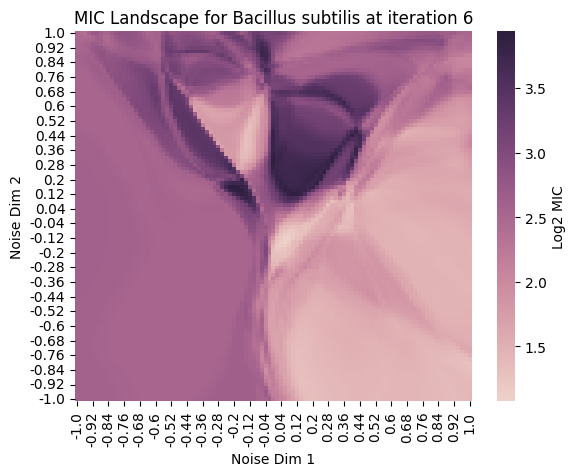

Iter 8/70; Average MIC 2.1860; Levenshtein 8.3691
          Peptide       MIC  Noise_1  Noise_2
5197  EVLKLDKFHLL  1.055289     0.02    -0.08


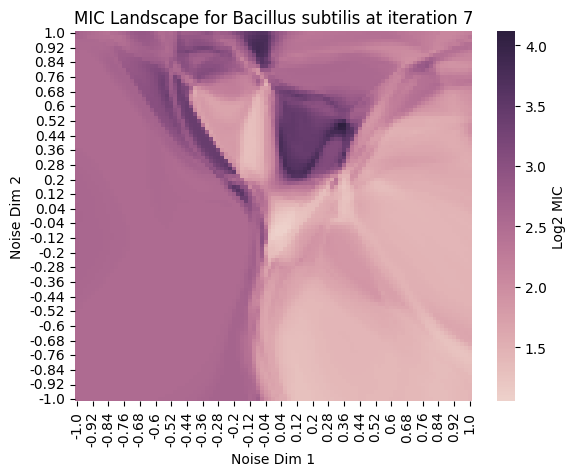

Iter 9/70; Average MIC 2.0814; Levenshtein 8.2432
             Peptide       MIC  Noise_1  Noise_2
6828  EVKKkDKKkKFFKK  1.038644     0.34     0.22


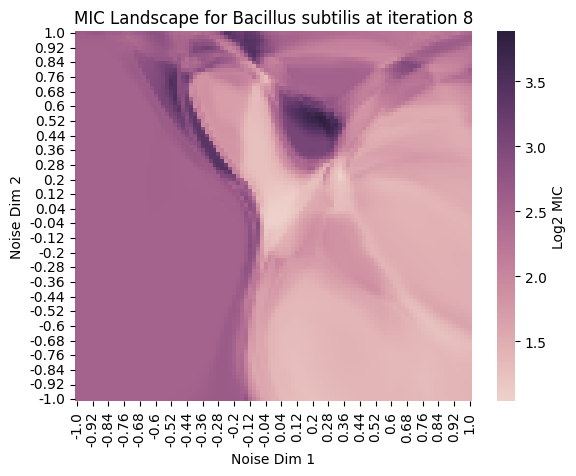

Iter 10/70; Average MIC 1.9927; Levenshtein 8.2249
          Peptide       MIC  Noise_1  Noise_2
4901  EVLKLDKFHLL  1.031986    -0.04     0.06


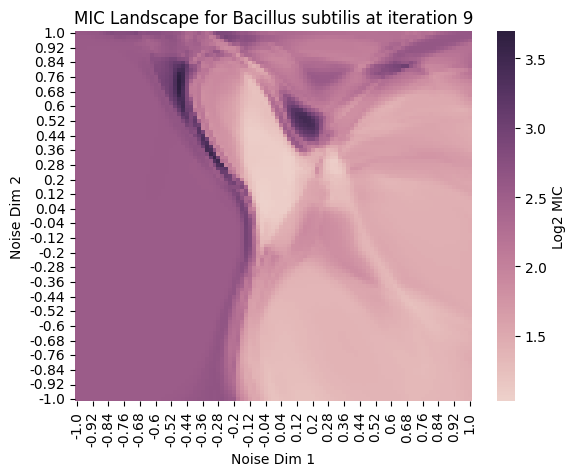

Iter 11/70; Average MIC 1.9332; Levenshtein 8.1522
          Peptide       MIC  Noise_1  Noise_2
5522  EVKKLDKFHLF  1.011517     0.08     0.36


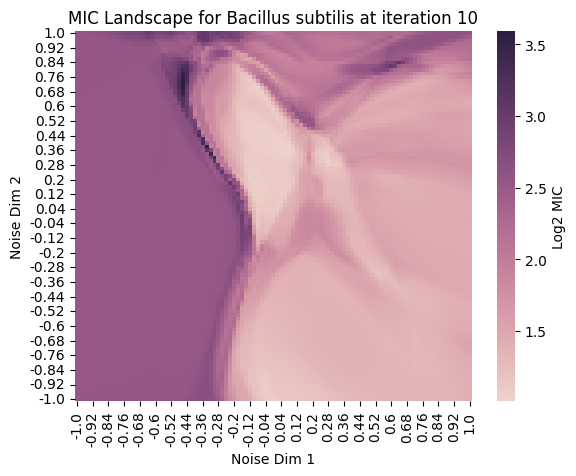

Iter 12/70; Average MIC 1.8800; Levenshtein 8.0798
             Peptide       MIC  Noise_1  Noise_2
4747  MVKKLAKKLKKLFK  0.920945    -0.06     -1.0


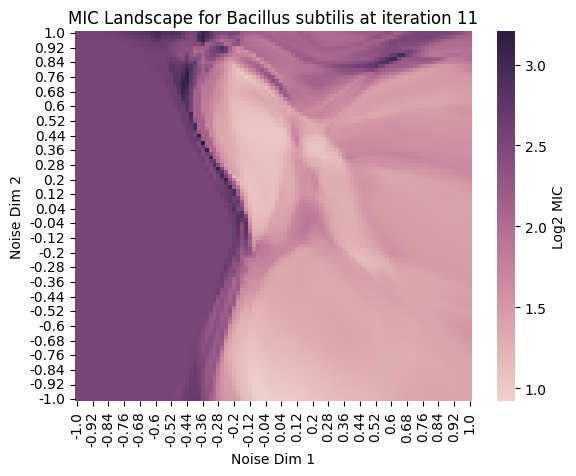

Iter 13/70; Average MIC 1.8212; Levenshtein 8.0191
             Peptide       MIC  Noise_1  Noise_2
4549  MVKKLAKKLKKLFK  0.871302     -0.1    -0.92


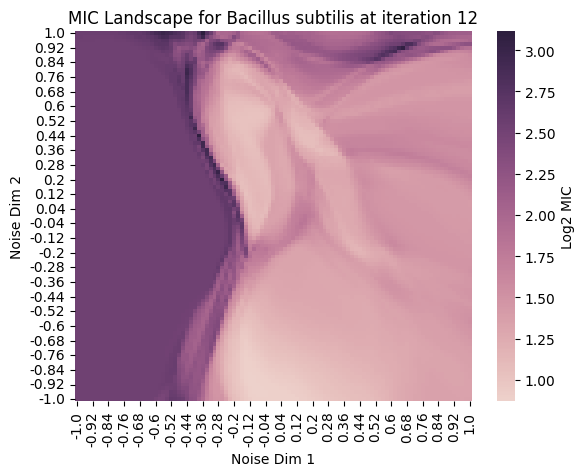

Iter 14/70; Average MIC 1.7525; Levenshtein 7.9698
             Peptide       MIC  Noise_1  Noise_2
5964  MVKKLAKKLKKLFK  0.885643     0.18     -0.9


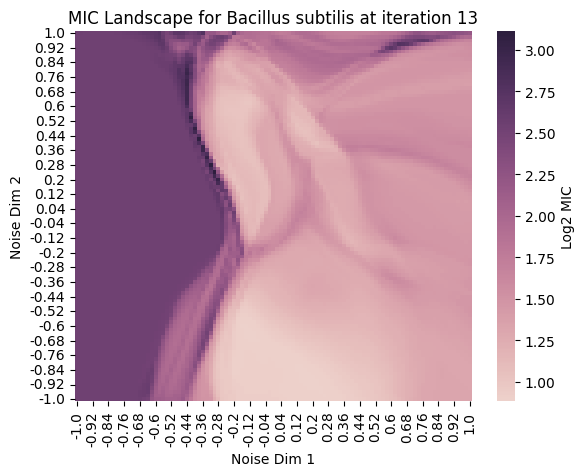

Iter 15/70; Average MIC 1.6832; Levenshtein 7.9110
             Peptide       MIC  Noise_1  Noise_2
4465  EVKKLAKKQKKLFK  0.859181    -0.12    -0.58


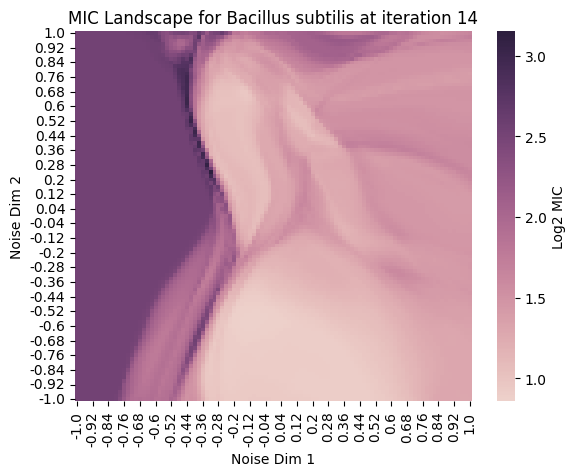

Iter 16/70; Average MIC 1.6083; Levenshtein 7.8847
             Peptide       MIC  Noise_1  Noise_2
4259  MVKKLAKKLKKLFK  0.839895    -0.16    -0.66


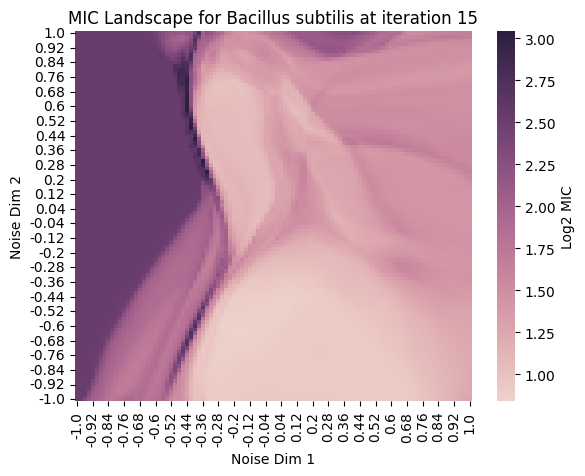

Iter 17/70; Average MIC 1.5228; Levenshtein 7.8815
             Peptide       MIC  Noise_1  Noise_2
3647  MVKKLAKKQKKLFK  0.816053    -0.28    -0.78


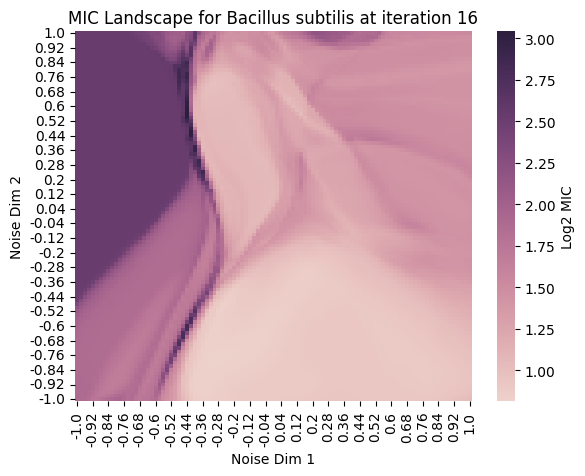

Iter 18/70; Average MIC 1.4473; Levenshtein 7.8996
             Peptide       MIC  Noise_1  Noise_2
3355  EVKKLAKKQKKLFK  0.801012    -0.34    -0.56


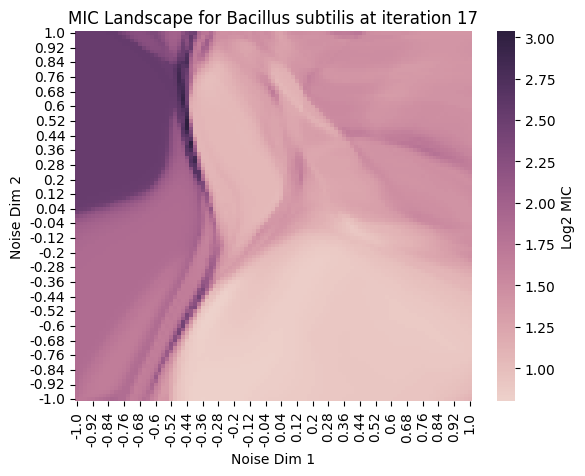

Iter 19/70; Average MIC 1.3597; Levenshtein 7.8392
             Peptide       MIC  Noise_1  Noise_2
3254  EVKKLAKKQKKLFK  0.791191    -0.36    -0.56


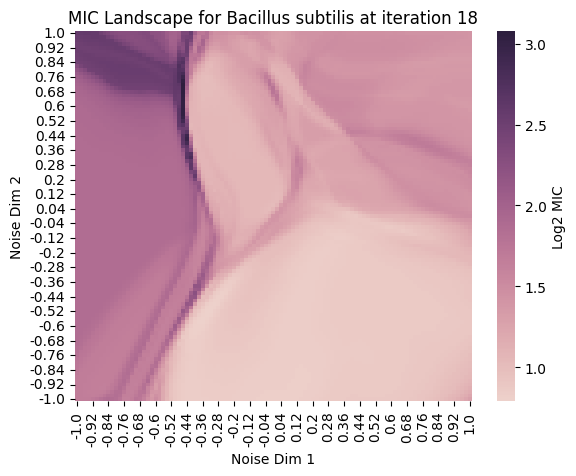

Iter 20/70; Average MIC 1.3112; Levenshtein 7.7269
             Peptide     MIC  Noise_1  Noise_2
3153  GVKKLAKKQKKLFK  0.7794    -0.38    -0.56


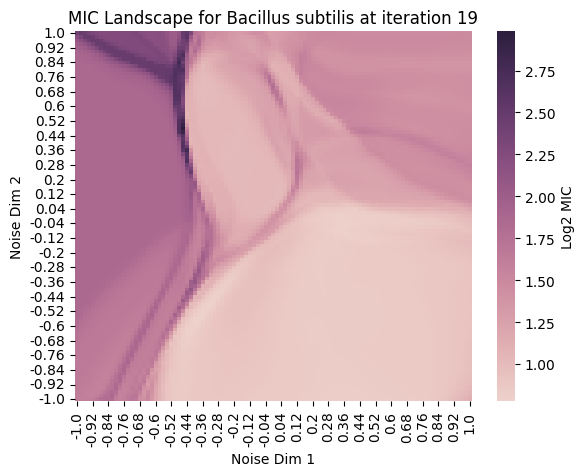

Iter 21/70; Average MIC 1.2704; Levenshtein 7.6770
             Peptide      MIC  Noise_1  Noise_2
3052  MVKKLAKKQKKLFK  0.75706     -0.4    -0.56


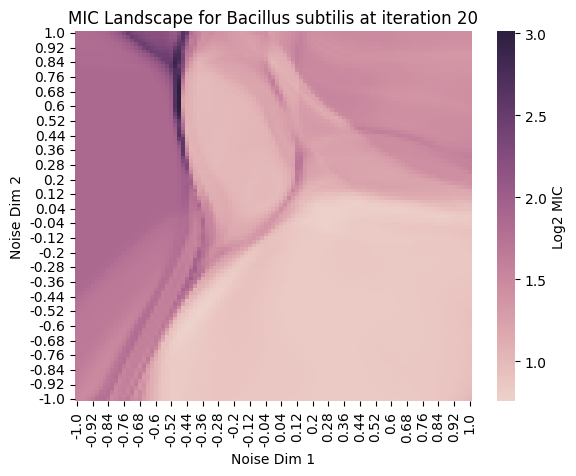

Iter 22/70; Average MIC 1.2376; Levenshtein 7.6269
             Peptide       MIC  Noise_1  Noise_2
3564  MVKKLAKKQKKLFK  0.741256     -0.3    -0.42


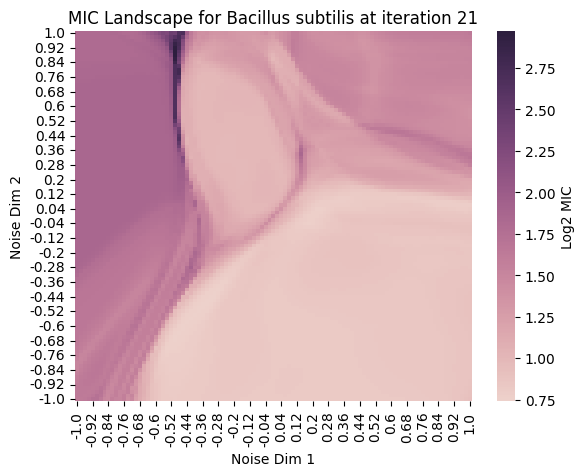

Iter 23/70; Average MIC 1.2051; Levenshtein 7.5268
             Peptide       MIC  Noise_1  Noise_2
3871  MVKKLAKKQKKLFK  0.741076    -0.24    -0.34


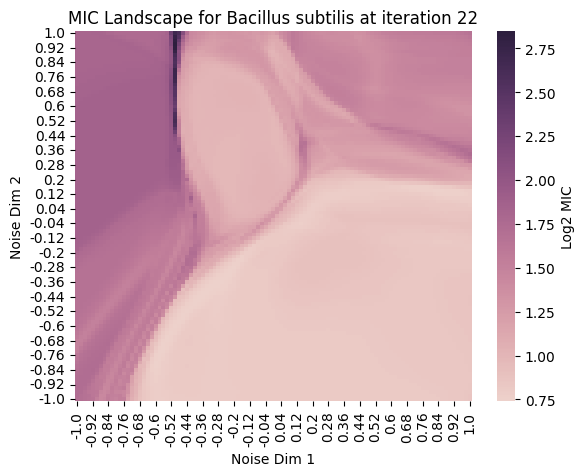

Iter 24/70; Average MIC 1.1733; Levenshtein 7.4164
             Peptide       MIC  Noise_1  Noise_2
3873  MVKKLAKKQKKLFK  0.725373    -0.24     -0.3


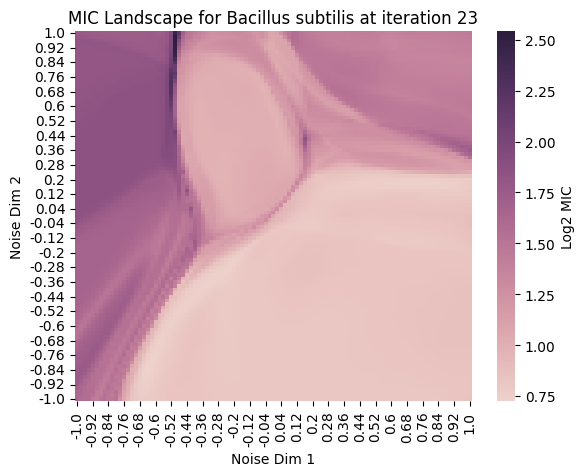

Iter 25/70; Average MIC 1.1486; Levenshtein 7.2608
             Peptide       MIC  Noise_1  Noise_2
1620  MVKKLAKKkKKLFK  0.708063    -0.68    -0.92


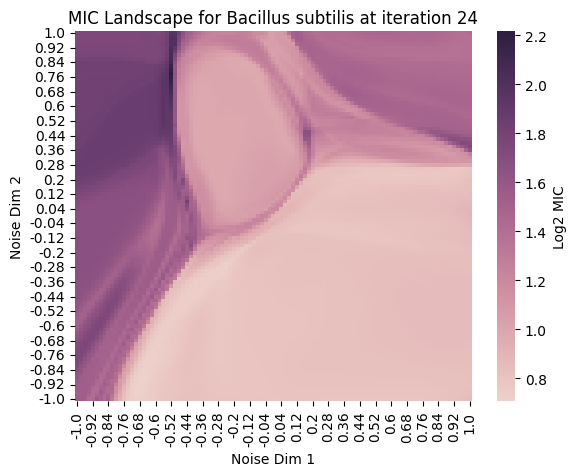

Iter 26/70; Average MIC 1.1169; Levenshtein 7.1144
             Peptide       MIC  Noise_1  Noise_2
3772  MVKKLAKKQKKLFK  0.707922    -0.26     -0.3


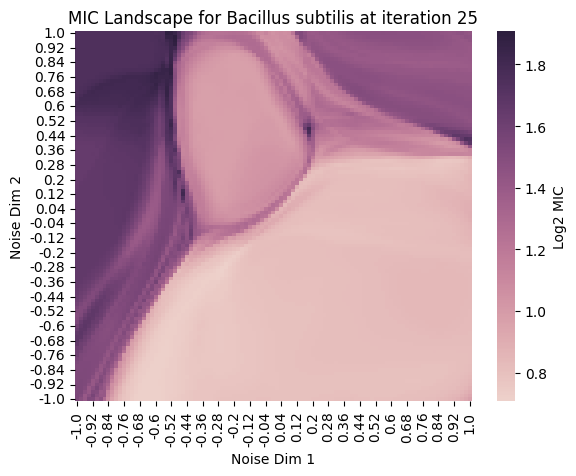

Iter 27/70; Average MIC 1.0834; Levenshtein 6.9397
             Peptide       MIC  Noise_1  Noise_2
3771  MVKKLAKKQKKLFK  0.701311    -0.26    -0.32


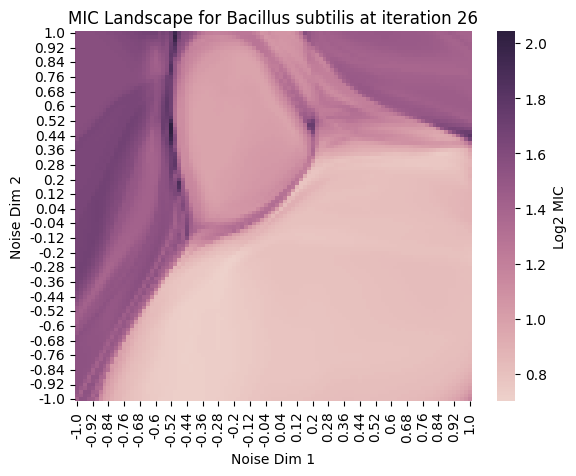

Iter 28/70; Average MIC 1.0654; Levenshtein 6.7174
             Peptide       MIC  Noise_1  Noise_2
3975  MVKKLAKKQKKLFK  0.693856    -0.22    -0.28


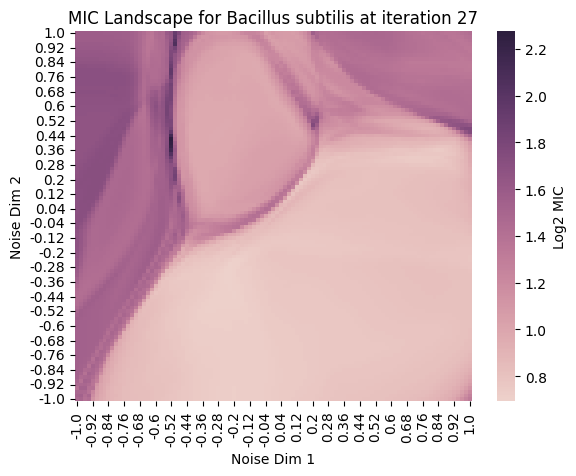

Iter 29/70; Average MIC 1.0513; Levenshtein 6.5543
             Peptide       MIC  Noise_1  Noise_2
4177  MVKKLAKKQKKLFK  0.687461    -0.18    -0.28


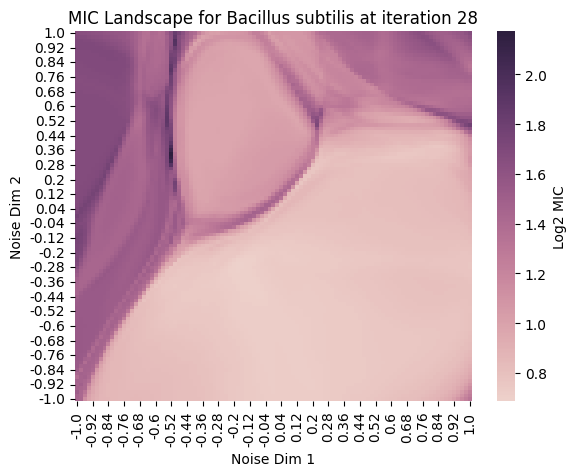

Iter 30/70; Average MIC 1.0278; Levenshtein 6.4058
             Peptide       MIC  Noise_1  Noise_2
6294  MVKKLAKKQKKLFK  0.691294     0.24    -0.36


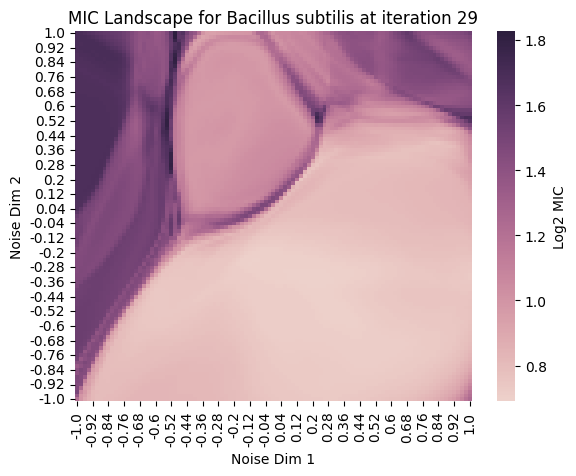

Iter 31/70; Average MIC 1.0036; Levenshtein 6.2416
             Peptide       MIC  Noise_1  Noise_2
8207  MVKKLAKKQKKLFK  0.689191     0.62    -0.48


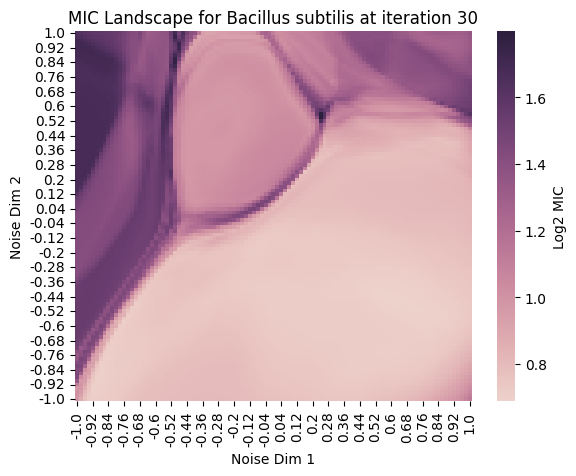

Iter 32/70; Average MIC 0.9854; Levenshtein 6.1509
             Peptide       MIC  Noise_1  Noise_2
8208  MVKKLAKKQKKLFK  0.707418     0.62    -0.46


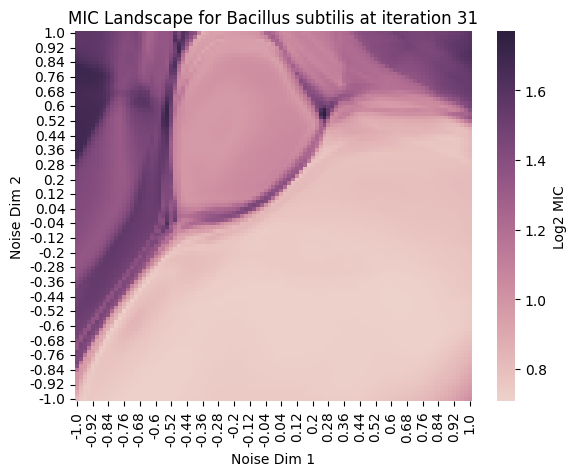

Iter 33/70; Average MIC 0.9674; Levenshtein 6.0473
             Peptide       MIC  Noise_1  Noise_2
8106  MVKKLAKKQKKLFK  0.694742      0.6    -0.48


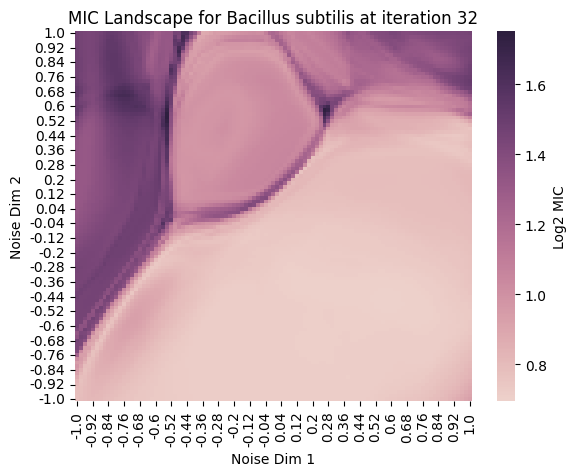

Iter 34/70; Average MIC 0.9523; Levenshtein 5.8949
             Peptide       MIC  Noise_1  Noise_2
6397  MVKKLAKKQKKLFK  0.689222     0.26    -0.32


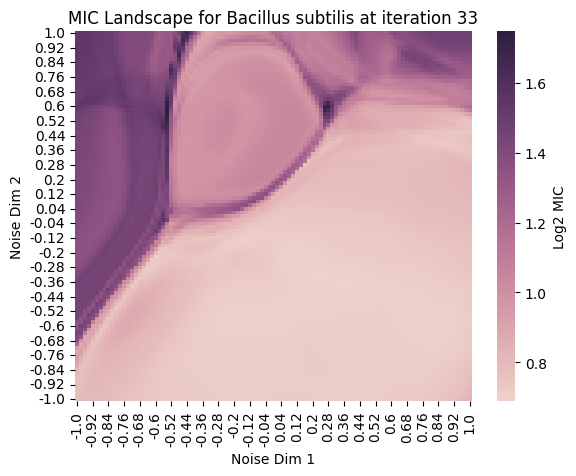

Iter 35/70; Average MIC 0.9353; Levenshtein 5.7432
             Peptide     MIC  Noise_1  Noise_2
6097  MVKKLAKKQKKLFK  0.6873      0.2    -0.26


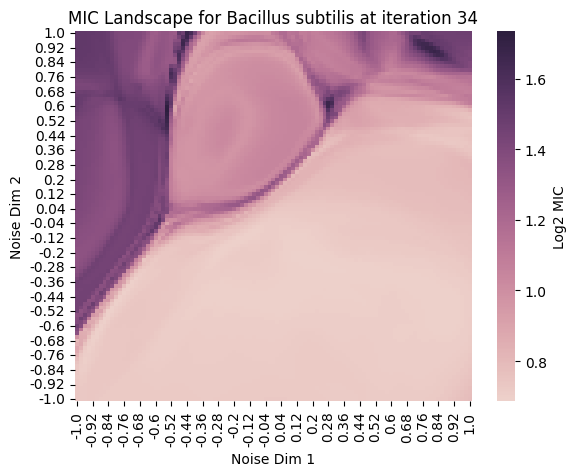

Iter 36/70; Average MIC 0.9191; Levenshtein 5.5333
             Peptide       MIC  Noise_1  Noise_2
4693  MVKKLAKKQKKLFK  0.688245    -0.08    -0.06


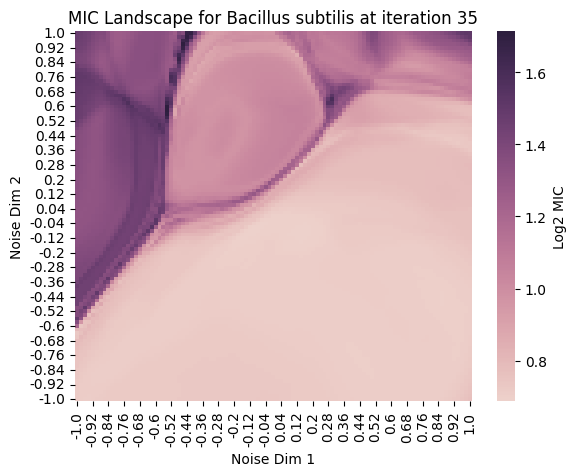

Iter 37/70; Average MIC 0.9132; Levenshtein 5.5469
             Peptide       MIC  Noise_1  Noise_2
4796  MVKKLAKKQKKLFK  0.688115    -0.06    -0.02


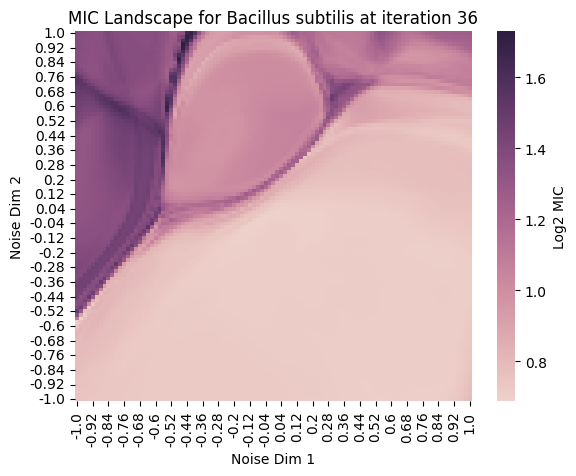

Iter 38/70; Average MIC 0.9038; Levenshtein 5.5020
           Peptide       MIC  Noise_1  Noise_2
125  MVKKLAKMWAKFK  0.677295    -0.98    -0.52


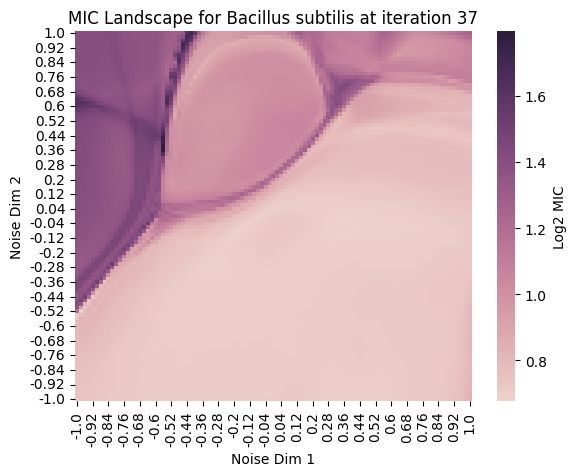

Iter 39/70; Average MIC 0.8966; Levenshtein 5.3599
             Peptide       MIC  Noise_1  Noise_2
3782  MVKKLAKKQKKLFK  0.686514    -0.26     -0.1


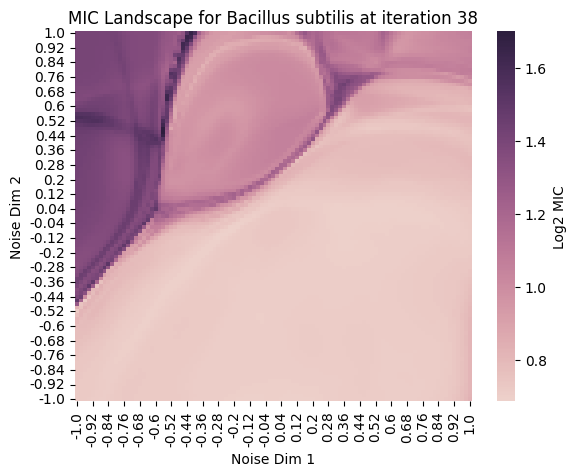

Iter 40/70; Average MIC 0.8792; Levenshtein 5.3024
             Peptide       MIC  Noise_1  Noise_2
2249  MVKKLAKKQKKLFK  0.680942    -0.56    -0.46


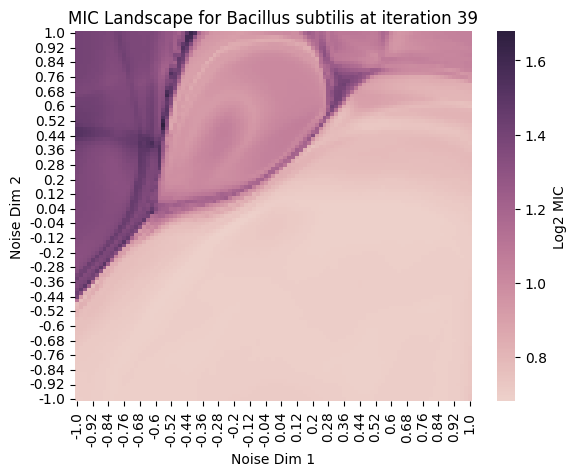

Iter 41/70; Average MIC 0.8764; Levenshtein 5.2667
             Peptide      MIC  Noise_1  Noise_2
3061  MVKKLAKKQKKLFK  0.68291     -0.4    -0.38


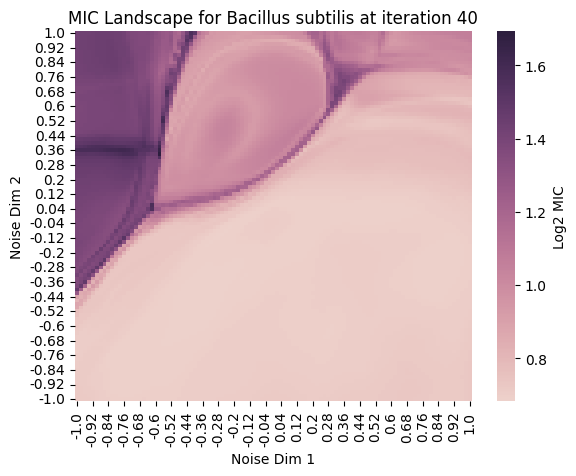

Iter 42/70; Average MIC 0.8649; Levenshtein 5.1287
             Peptide       MIC  Noise_1  Noise_2
3863  MVKKLAKKQKKLFK  0.681288    -0.24     -0.5


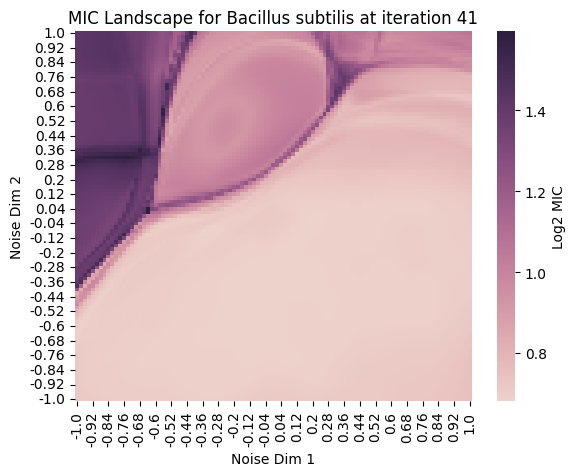

Iter 43/70; Average MIC 0.8561; Levenshtein 4.9502
             Peptide      MIC  Noise_1  Noise_2
3080  MVKKLAKKkKKLAK  0.67472     -0.4      0.0


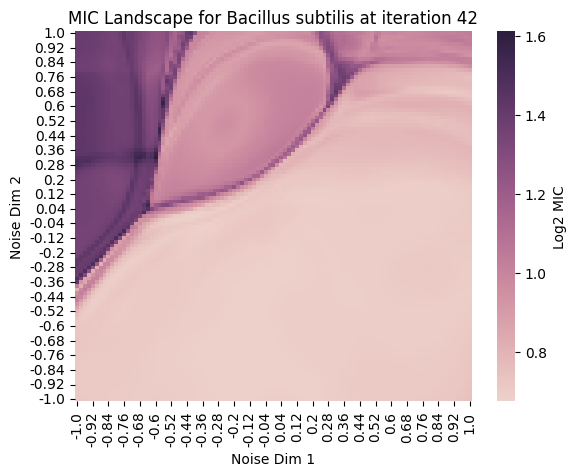

Iter 44/70; Average MIC 0.8451; Levenshtein 4.9430
             Peptide       MIC  Noise_1  Noise_2
2878  MVKKLAKKkKKLAK  0.661062    -0.44      0.0


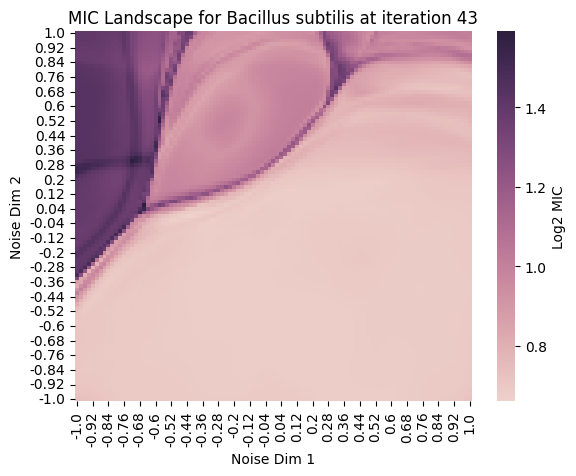

Iter 45/70; Average MIC 0.8335; Levenshtein 4.8596
             Peptide       MIC  Noise_1  Noise_2
2777  MVKKLAKKkKKLFK  0.663069    -0.46      0.0


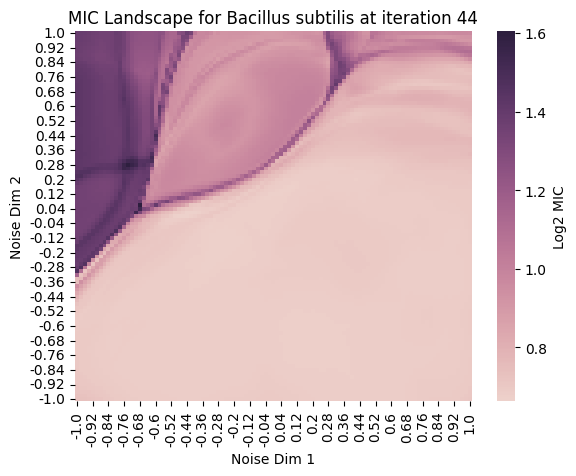

Iter 46/70; Average MIC 0.8216; Levenshtein 4.7255
             Peptide       MIC  Noise_1  Noise_2
7431  MVKKLAKKQKKLFK  0.661054     0.46     0.16


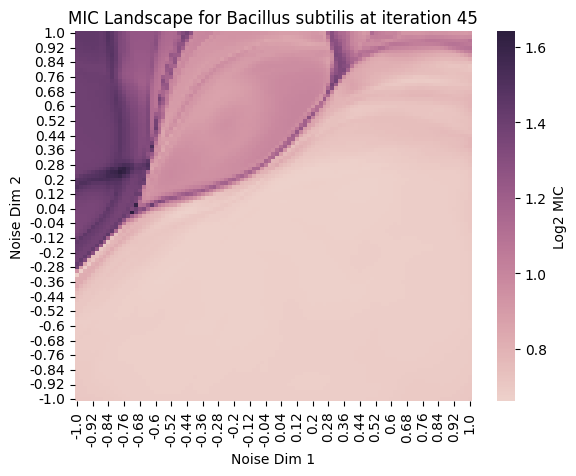

Iter 47/70; Average MIC 0.8102; Levenshtein 4.8153
              Peptide       MIC  Noise_1  Noise_2
6731  MVKKLAKKQKKLAKA  0.634378     0.32      0.3


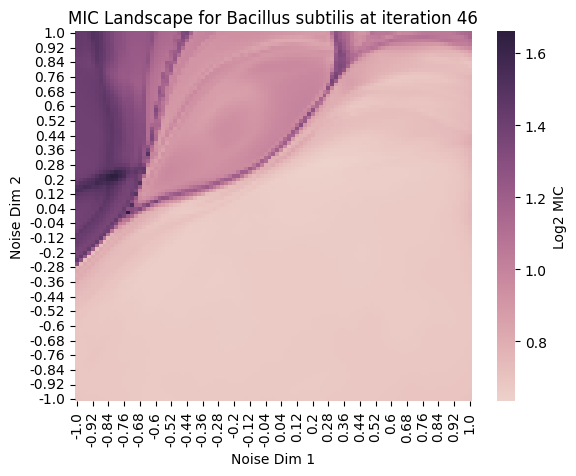

Iter 48/70; Average MIC 0.7889; Levenshtein 4.9872
              Peptide       MIC  Noise_1  Noise_2
6223  MVKKLAKKQKKLFKA  0.601307     0.22     0.24


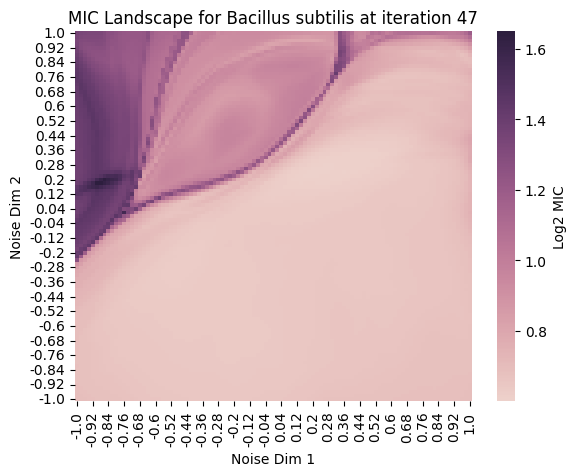

Iter 49/70; Average MIC 0.7645; Levenshtein 5.0174
              Peptide      MIC  Noise_1  Noise_2
7740  MVKKLAKKcKKLFKA  0.58414     0.52     0.28


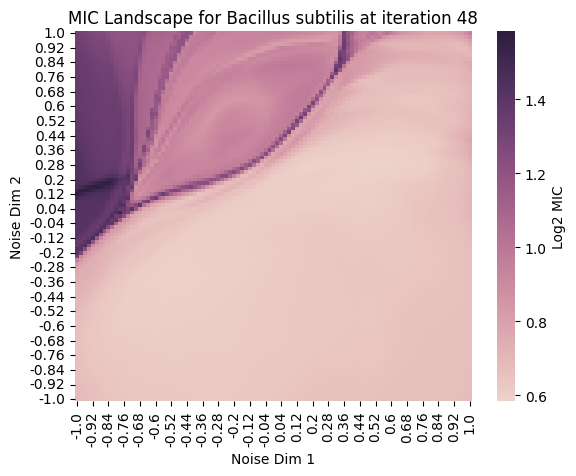

Iter 50/70; Average MIC 0.7359; Levenshtein 4.9534
              Peptide       MIC  Noise_1  Noise_2
8953  MVKKLAKKcKKLFKA  0.569677     0.76      0.3


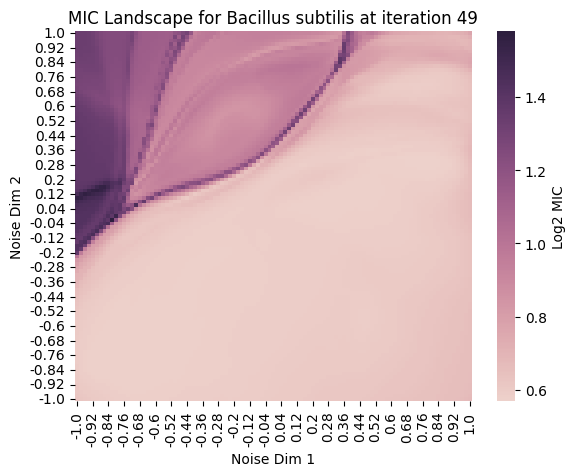

Iter 51/70; Average MIC 0.7084; Levenshtein 4.7670
           Peptide       MIC  Noise_1  Noise_2
9  MVKKLAKKQKKLFKA  0.542078     -1.0    -0.82


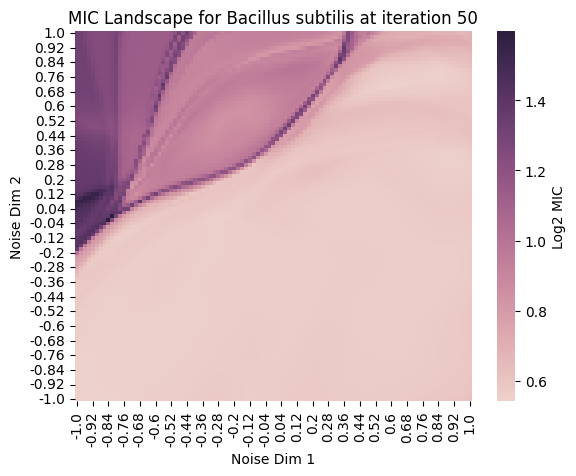

Iter 52/70; Average MIC 0.6908; Levenshtein 4.6717
             Peptide       MIC  Noise_1  Noise_2
934  MVKKLAKKcKKLFKA  0.526865    -0.82     -0.5


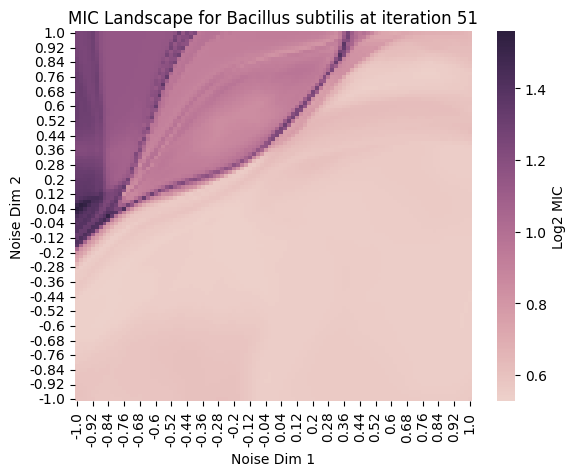

Iter 53/70; Average MIC 0.6679; Levenshtein 4.6307
              Peptide       MIC  Noise_1  Noise_2
526  MVKKLAKKQKKLFDKA  0.492618     -0.9    -0.58


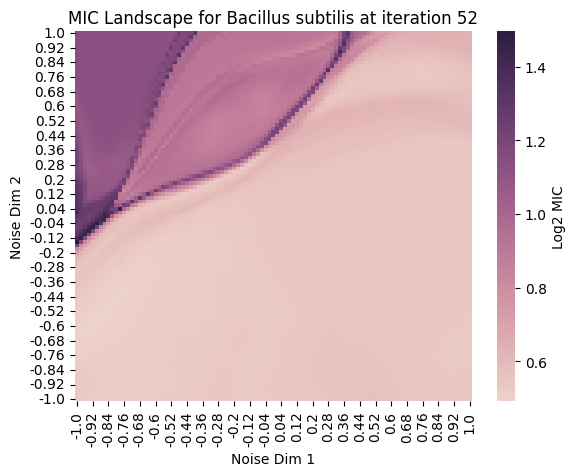

Iter 54/70; Average MIC 0.6548; Levenshtein 4.6508
               Peptide       MIC  Noise_1  Noise_2
1447  MVKKLAKKcKKLADKA  0.456152    -0.72    -0.34


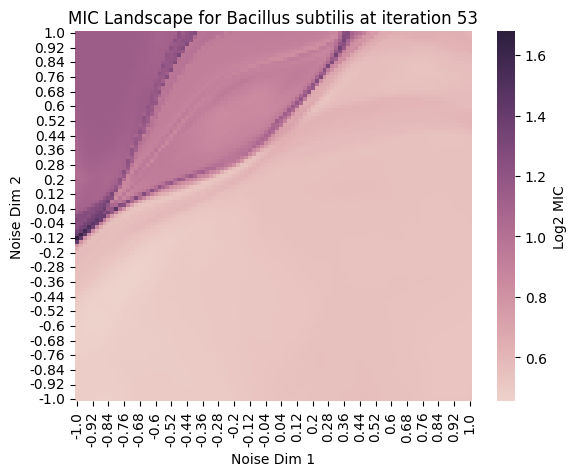

Iter 55/70; Average MIC 0.6382; Levenshtein 4.8203
             Peptide       MIC  Noise_1  Noise_2
20  MVKKLAKKQKKLADKA  0.413403     -1.0     -0.6


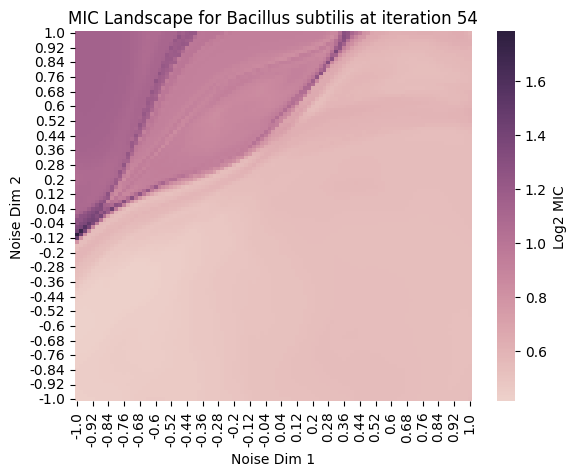

Iter 56/70; Average MIC 0.6145; Levenshtein 4.9223
               Peptide       MIC  Noise_1  Noise_2
2151  MVKKLAKKcKKLADKA  0.374941    -0.58     -0.4


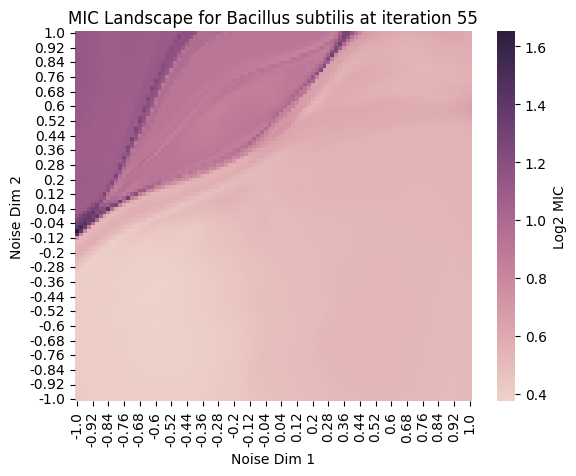

Iter 57/70; Average MIC 0.5943; Levenshtein 4.9600
             Peptide       MIC  Noise_1  Noise_2
38  MVKKLAKKkKKLADKA  0.348829     -1.0    -0.24


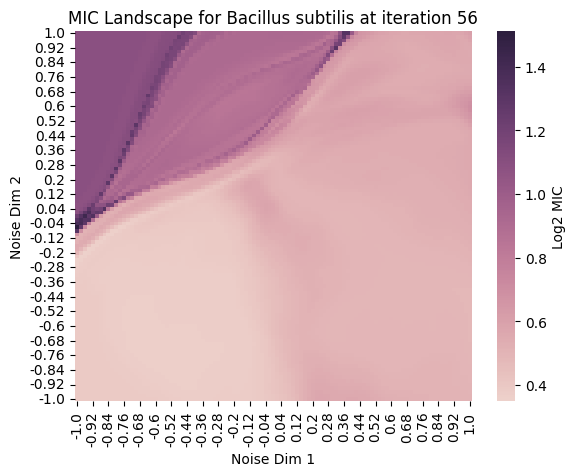

Iter 58/70; Average MIC 0.5745; Levenshtein 4.8729
               Peptide       MIC  Noise_1  Noise_2
1058  MVKKLAKKkKKLADKA  0.337403     -0.8    -0.04


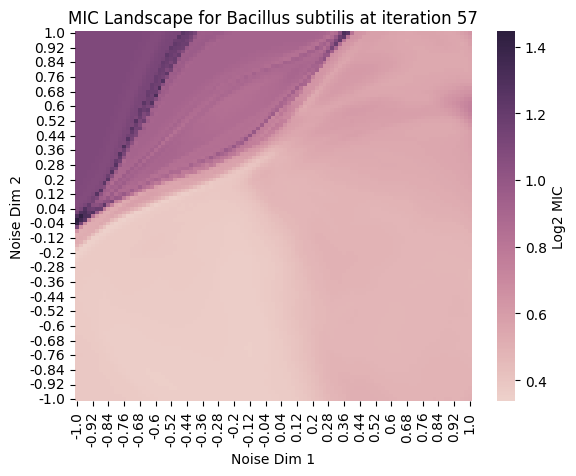

Iter 59/70; Average MIC 0.5579; Levenshtein 4.7752
              Peptide      MIC  Noise_1  Noise_2
245  MVKKLAKKkKKLADKA  0.32072    -0.96    -0.14


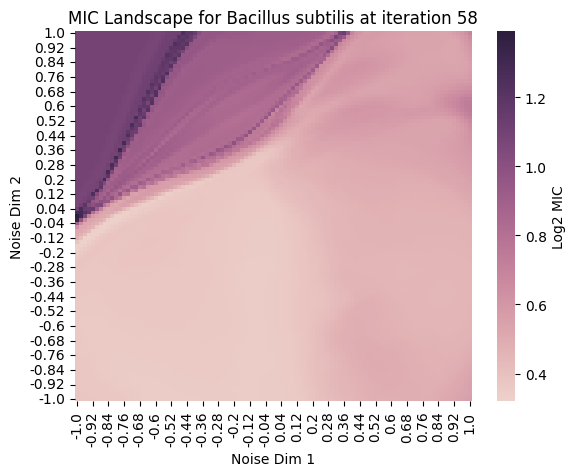

Iter 60/70; Average MIC 0.5347; Levenshtein 4.6456
              Peptide       MIC  Noise_1  Noise_2
959  MVKKLAKKkKKLADKA  0.297072    -0.82      0.0


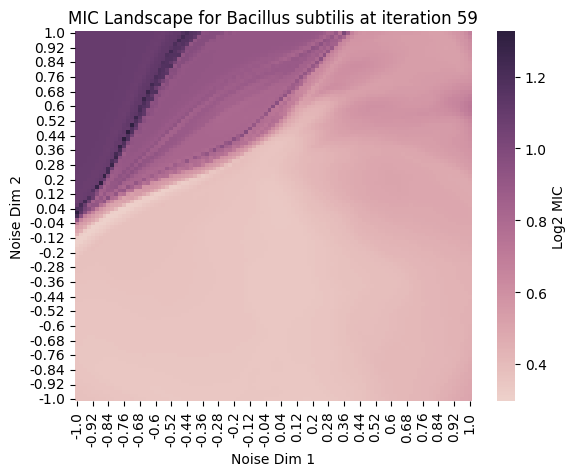

Iter 61/70; Average MIC 0.5149; Levenshtein 4.5066
               Peptide      MIC  Noise_1  Noise_2
2787  MVKKLAKKkKKLADKA  0.27823    -0.46      0.2


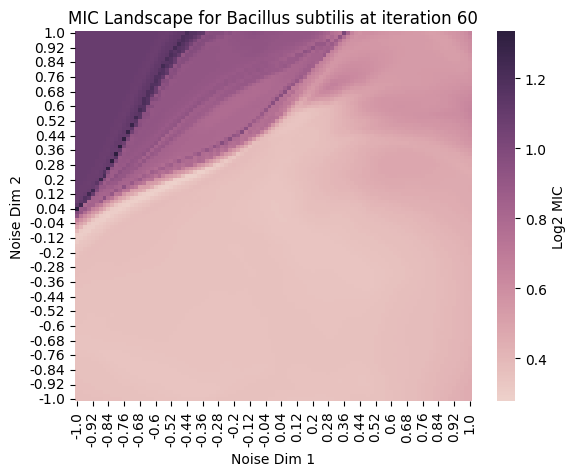

Iter 62/70; Average MIC 0.4979; Levenshtein 4.2967
               Peptide       MIC  Noise_1  Noise_2
3397  MVKKLAKKkKKLADKA  0.265054    -0.34     0.28


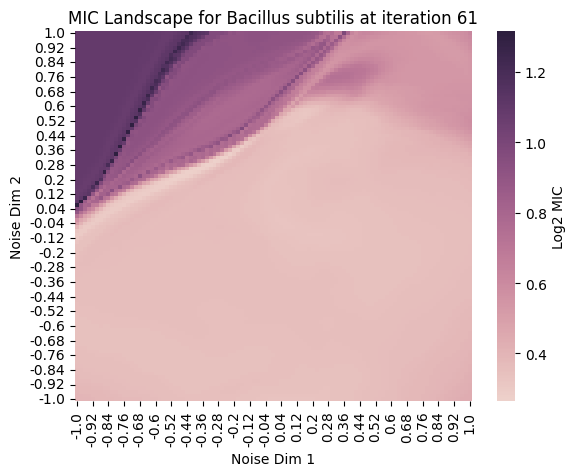

Iter 63/70; Average MIC 0.4882; Levenshtein 4.1931
               Peptide       MIC  Noise_1  Noise_2
3804  MVKKLAKKkKKLADKA  0.254314    -0.26     0.34


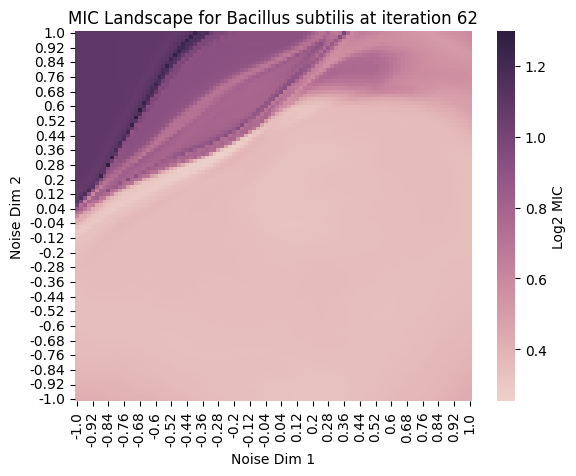

Iter 64/70; Average MIC 0.4766; Levenshtein 4.2026
               Peptide       MIC  Noise_1  Noise_2
4008  MVKKLAKKkKKLADKA  0.253072    -0.22     0.38


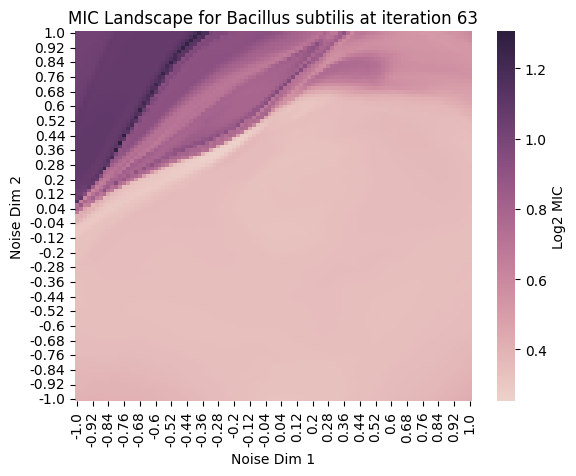

Iter 65/70; Average MIC 0.4626; Levenshtein 4.1477
               Peptide      MIC  Noise_1  Noise_2
4009  MVKKLAKKkKKLADKA  0.24953    -0.22      0.4


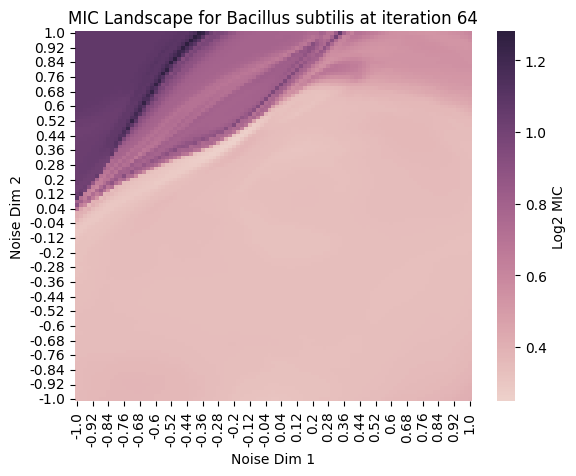

Iter 66/70; Average MIC 0.4494; Levenshtein 4.1305
               Peptide       MIC  Noise_1  Noise_2
4315  MVKKLAKKkKKLADKA  0.245585    -0.16     0.46


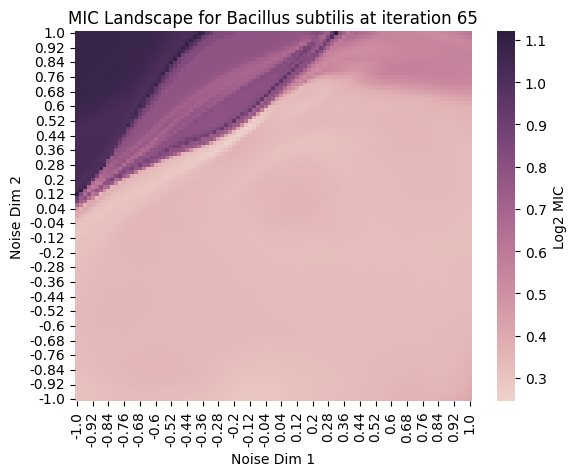

Iter 67/70; Average MIC 0.4378; Levenshtein 4.0527
               Peptide       MIC  Noise_1  Noise_2
4112  MVKKLAKKkKKLADKA  0.251876     -0.2     0.44


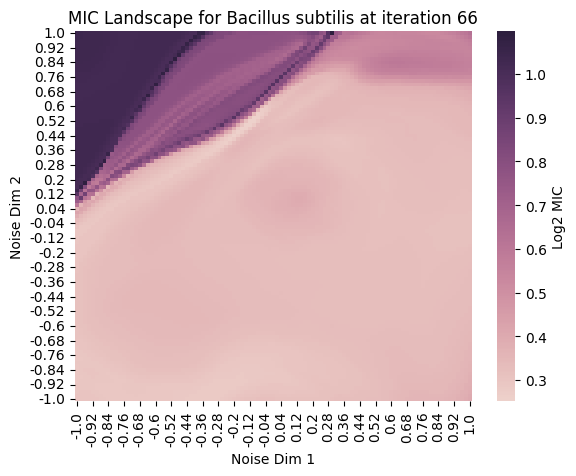

Iter 68/70; Average MIC 0.4285; Levenshtein 3.9976
               Peptide       MIC  Noise_1  Noise_2
4622  MVKKLAKKkKKLADKA  0.248343     -0.1     0.54


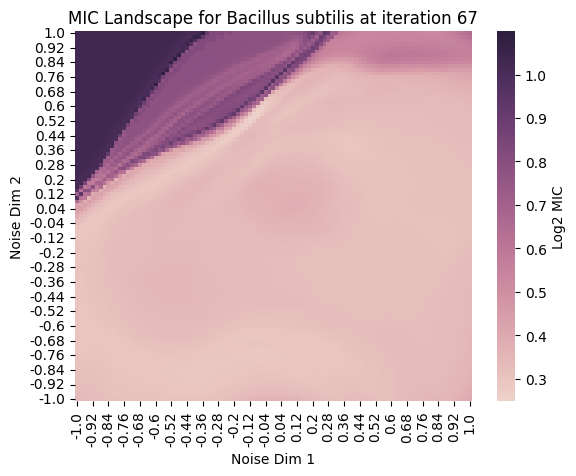

Iter 69/70; Average MIC 0.4178; Levenshtein 3.9181
               Peptide       MIC  Noise_1  Noise_2
4623  MVKKLAKKkKKLADKA  0.246553     -0.1     0.56


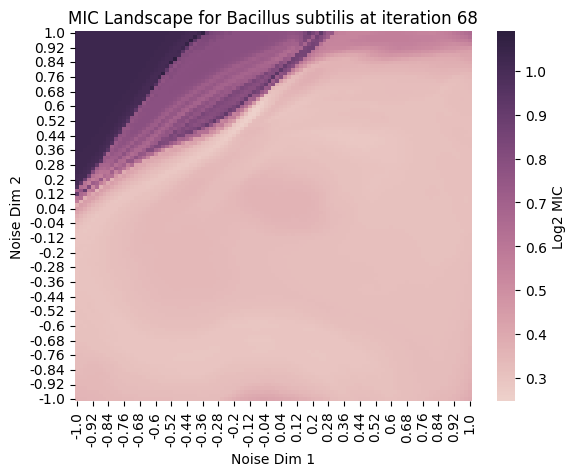

Iter 70/70; Average MIC 0.4068; Levenshtein 4.0332
               Peptide       MIC  Noise_1  Noise_2
4523  MVKKLAKKkKKLADKA  0.244181    -0.12     0.58


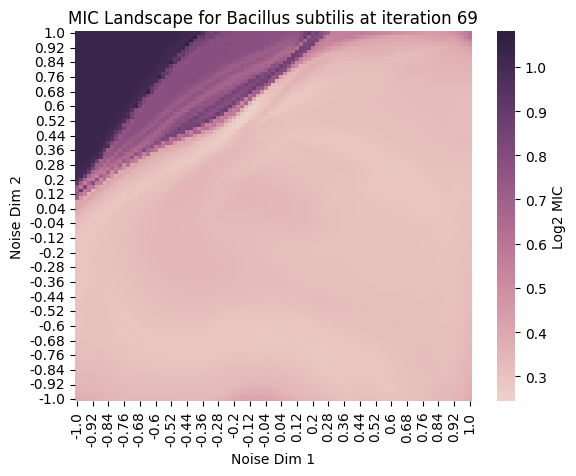

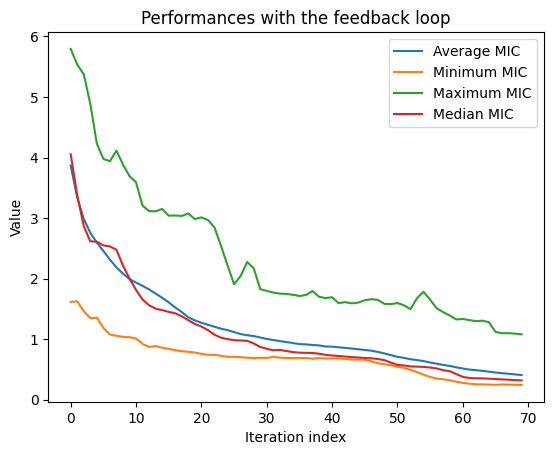

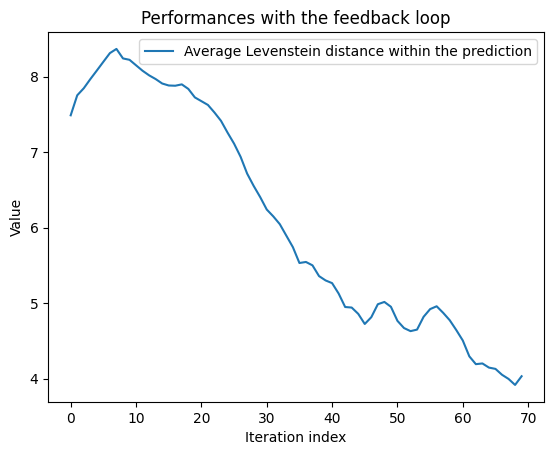

['MVKKLAKKcKKLADKAL',
 'MVKKLAKKcKKLADKFA',
 'MVKKLAKKcKKLADKAL',
 'MVKKLAKKcKKLADKFAE',
 'KVIVkDKFHLWKA',
 'MVKKLAKKQKKLADKAM',
 'MVKKLAKKkKKLADKAL',
 'KVIKkDKFHLFKA',
 'MVKKLAKKcKKLADKAL',
 'MVKKLAKKQKKLADKFA']

In [17]:
latent_dim = 2
n_iter_max = 70
n_bins = 101
target = 'Bacillus_subtilis'

average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein = RL_loop(generator, oracle, aa_vocal, pep_decoder, n_bins, target)
display({"Average MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})
display({"Average Levenstein distance within the prediction" : levenstein})
generate_sequences(generator, latent_dim, 10)

In [18]:
generator.save(f"/content/AMPLify-Feedback-main/Bacterium2Peptide/PeptideGenerator_{target}_{n_iter_max}.keras")